#Init

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

plt.style.use('dark_background')

import seaborn as sb

from pylab import rcParams
rcParams['figure.figsize'] = 4, 3

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

In [2]:
!gdown --id 1Y7mlx-fxYERHAiwcukT-RaI2Ovzkml0y

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y7mlx-fxYERHAiwcukT-RaI2Ovzkml0y
To: /content/titanic.zip
100% 22.5k/22.5k [00:00<00:00, 41.4MB/s]


In [3]:
!unzip '/content/titanic.zip'

Archive:  /content/titanic.zip
  inflating: train.csv               


In [4]:
df = pd.read_csv('/content/train.csv')

In [5]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C
401,402,0,3,"Adams, Mr. John",male,26.0,0,0,341826,8.0500,NaN,S
206,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S
76,77,0,3,"Staneff, Mr. Ivan",male,NaN,0,0,349208,7.8958,NaN,S
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
387,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S


#EDA



In [43]:
pd.DataFrame(df.isna().mean().sort_values(ascending=False))

,0
Cabin,0.771044
Age,0.198653
Embarked,0.002245
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
SibSp,0.000000
Parch,0.000000


In [ ]:
q1 = df['Age'].quantile(0.95)

In [ ]:
df['Age_group'] = pd.qcut(df['Age_nona'], 4)

In [ ]:
df[df['Pclass'] == 3]['Fare'].sort_values(ascending=False).median()

8.05

In [ ]:
df.groupby(['Survived', 'Sex'], as_index=False, dropna=False).agg({'Age': ['mean', 'median', 'count'], 'PassengerId': 'count'}).sort_values(('Age', 'count'), ascending=False)

Survived     Sex        Age              PassengerId
                         mean median count       count
1        0    male  31.618056   29.0   360         468
2        1  female  28.847716   28.0   197         233
3        1    male  27.276022   28.0    93         109
0        0  female  25.046875   24.5    64          81

<Axes: >

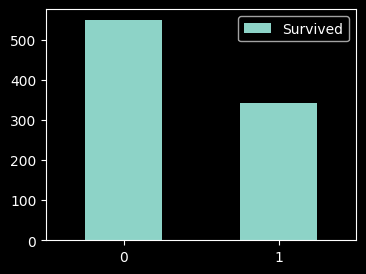

In [ ]:
df.groupby(['Survived'], as_index=False, dropna=False).agg({'Survived': 'count'}).sort_values('Survived', ascending=False).plot(kind='bar', rot=0)

In [ ]:
df.shape

(891, 17)

<Axes: xlabel='Sex', ylabel='Count'>

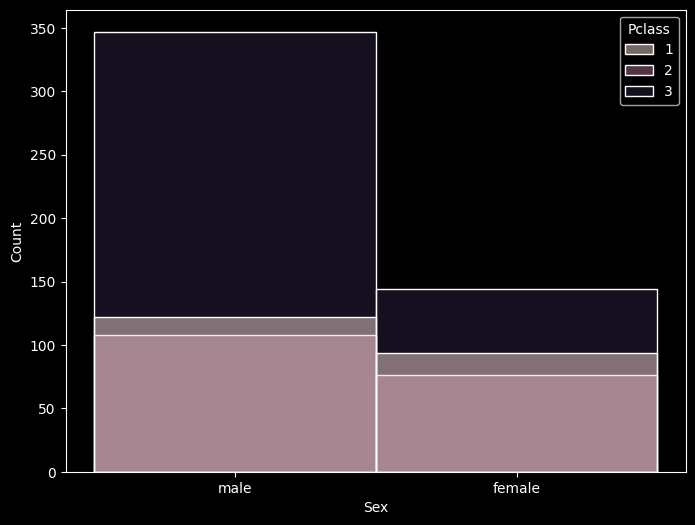

In [119]:
plt.figure(figsize=(8, 6))
sb.histplot(x='Sex', data=df, hue='Pclass')

In [ ]:
df.isna().mean()

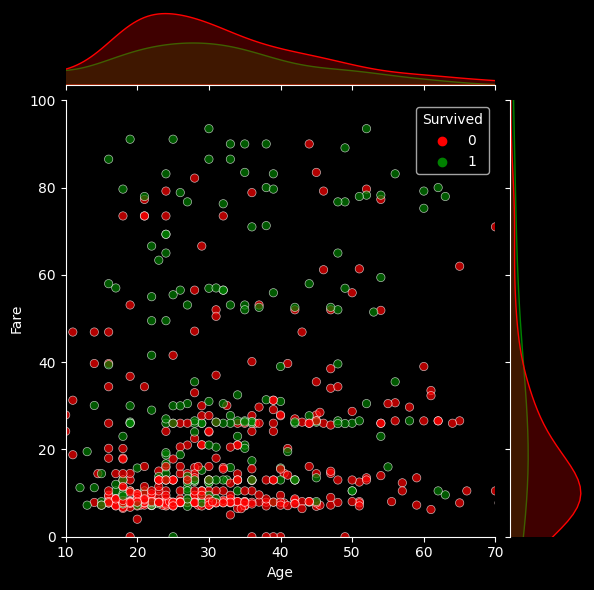

In [137]:
sb.jointplot(data=df, x=df['Age'], y=df['Fare'], kind='scatter', alpha=0.7, hue=df['Survived'], palette=['r','g'])
plt.xlim(10, 70);
plt.ylim(0, 100);

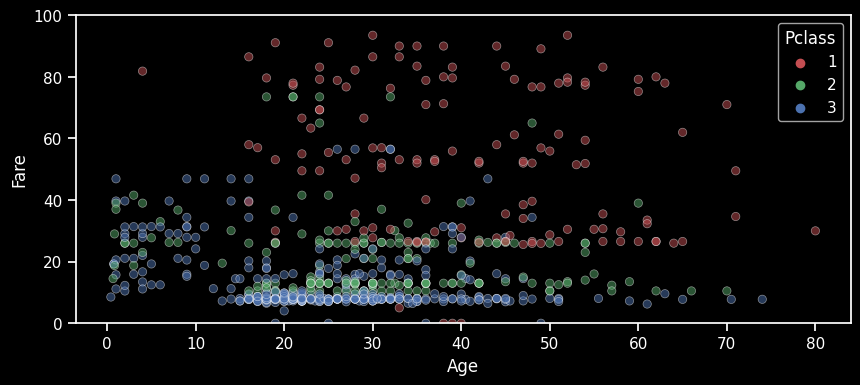

In [12]:
plt.figure(figsize=(10, 4))
sb.scatterplot(x=df['Age'], y=df['Fare'], hue=df['Pclass'], palette=['r','g','b'], alpha=0.5)
plt.ylim(0, 100);

#ML

##Replace Str to Int
Меняем категориальные фичи на цифры

In [6]:
df['Age_nona'] = df['Age'].fillna(df['Age'].mean())

In [7]:
replace_sex = {'male': 1, 'female': 0}

df['Sex_num'] = df['Sex'].replace(replace_sex)

In [8]:
df['Embarked_nona'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

replace_embarked = {'S': 1, 'C': 0, 'Q': 2}

df['Embarked_num'] = df['Embarked_nona'].replace(replace_embarked)

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_nona,Sex_num,Embarked_nona,Embarked_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,1,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,0,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,0,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,0,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,1,S,1


## Train, Test

In [25]:
X = [ 'Pclass', 'SibSp', 'Parch', 'Sex_num', 'Embarked_num', 'Fare', 'Age_nona']
y = ['Survived']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.3, random_state=50)

In [27]:
list_to_std = ['Parch']

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[list_to_std])


X_train_std = pd.DataFrame(scaler.transform(X_train[list_to_std]), columns=list_to_std)

In [29]:
means = X_train.mean()
stds = X_train.std()

mins = X_train.min()
maxs = X_train.max()

#display(means, stds)

In [30]:
X_train_std = X_train
X_train_std[list_to_std] = (X_train[list_to_std] - means[list_to_std]) / stds[list_to_std]

In [31]:
#X_train[['Age_nona', 'Fare']] = (X_train[['Age_nona', 'Fare']] - mins[['Age_nona', 'Fare']]) / (maxs[['Age_nona', 'Fare']] - mins[['Age_nona', 'Fare']])

In [32]:
X_train_std.isna().mean()

Pclass          0.0
SibSp           0.0
Parch           0.0
Sex_num         0.0
Embarked_num    0.0
Fare            0.0
Age_nona        0.0
dtype: float64

In [33]:
X_train_std.describe()

,Pclass,SibSp,Parch,Sex_num,Embarked_num,Fare,Age_nona
count,623.000000,623.000000,6.230000e+02,623.000000,623.000000,623.000000,623.000000
mean,2.263242,0.516854,5.702590e-18,0.651685,0.890851,34.090007,30.216761
std,0.853241,1.080054,1.000000e+00,0.476819,0.508098,51.157584,12.905714
min,1.000000,0.000000,-4.665208e-01,0.000000,0.000000,0.000000,0.420000
25%,1.000000,0.000000,-4.665208e-01,0.000000,1.000000,8.039600,22.000000
50%,3.000000,0.000000,-4.665208e-01,1.000000,1.000000,15.500000,29.699118
75%,3.000000,1.000000,-4.665208e-01,1.000000,1.000000,31.854150,35.500000
max,3.000000,8.000000,6.021035e+00,1.000000,2.000000,512.329200,80.000000


In [34]:
log_reg = LogisticRegression(max_iter=500)

In [ ]:
log_reg.fit(X_train_std, y_train.values.ravel())

In [36]:
log_reg.score(X_test, y_test)

0.8022388059701493

In [37]:
survival = log_reg.predict(X_test)
print("OK ", sum(survival!=0))
print("NOT OK", sum(survival==0))

OK  89
NOT OK 179


## Confusion Matrix


array([[144,  18],
       [ 35,  71]])

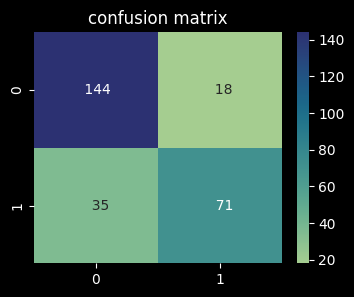

In [38]:
conf_mx = confusion_matrix(y_test, survival)

sb.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=12)
conf_mx